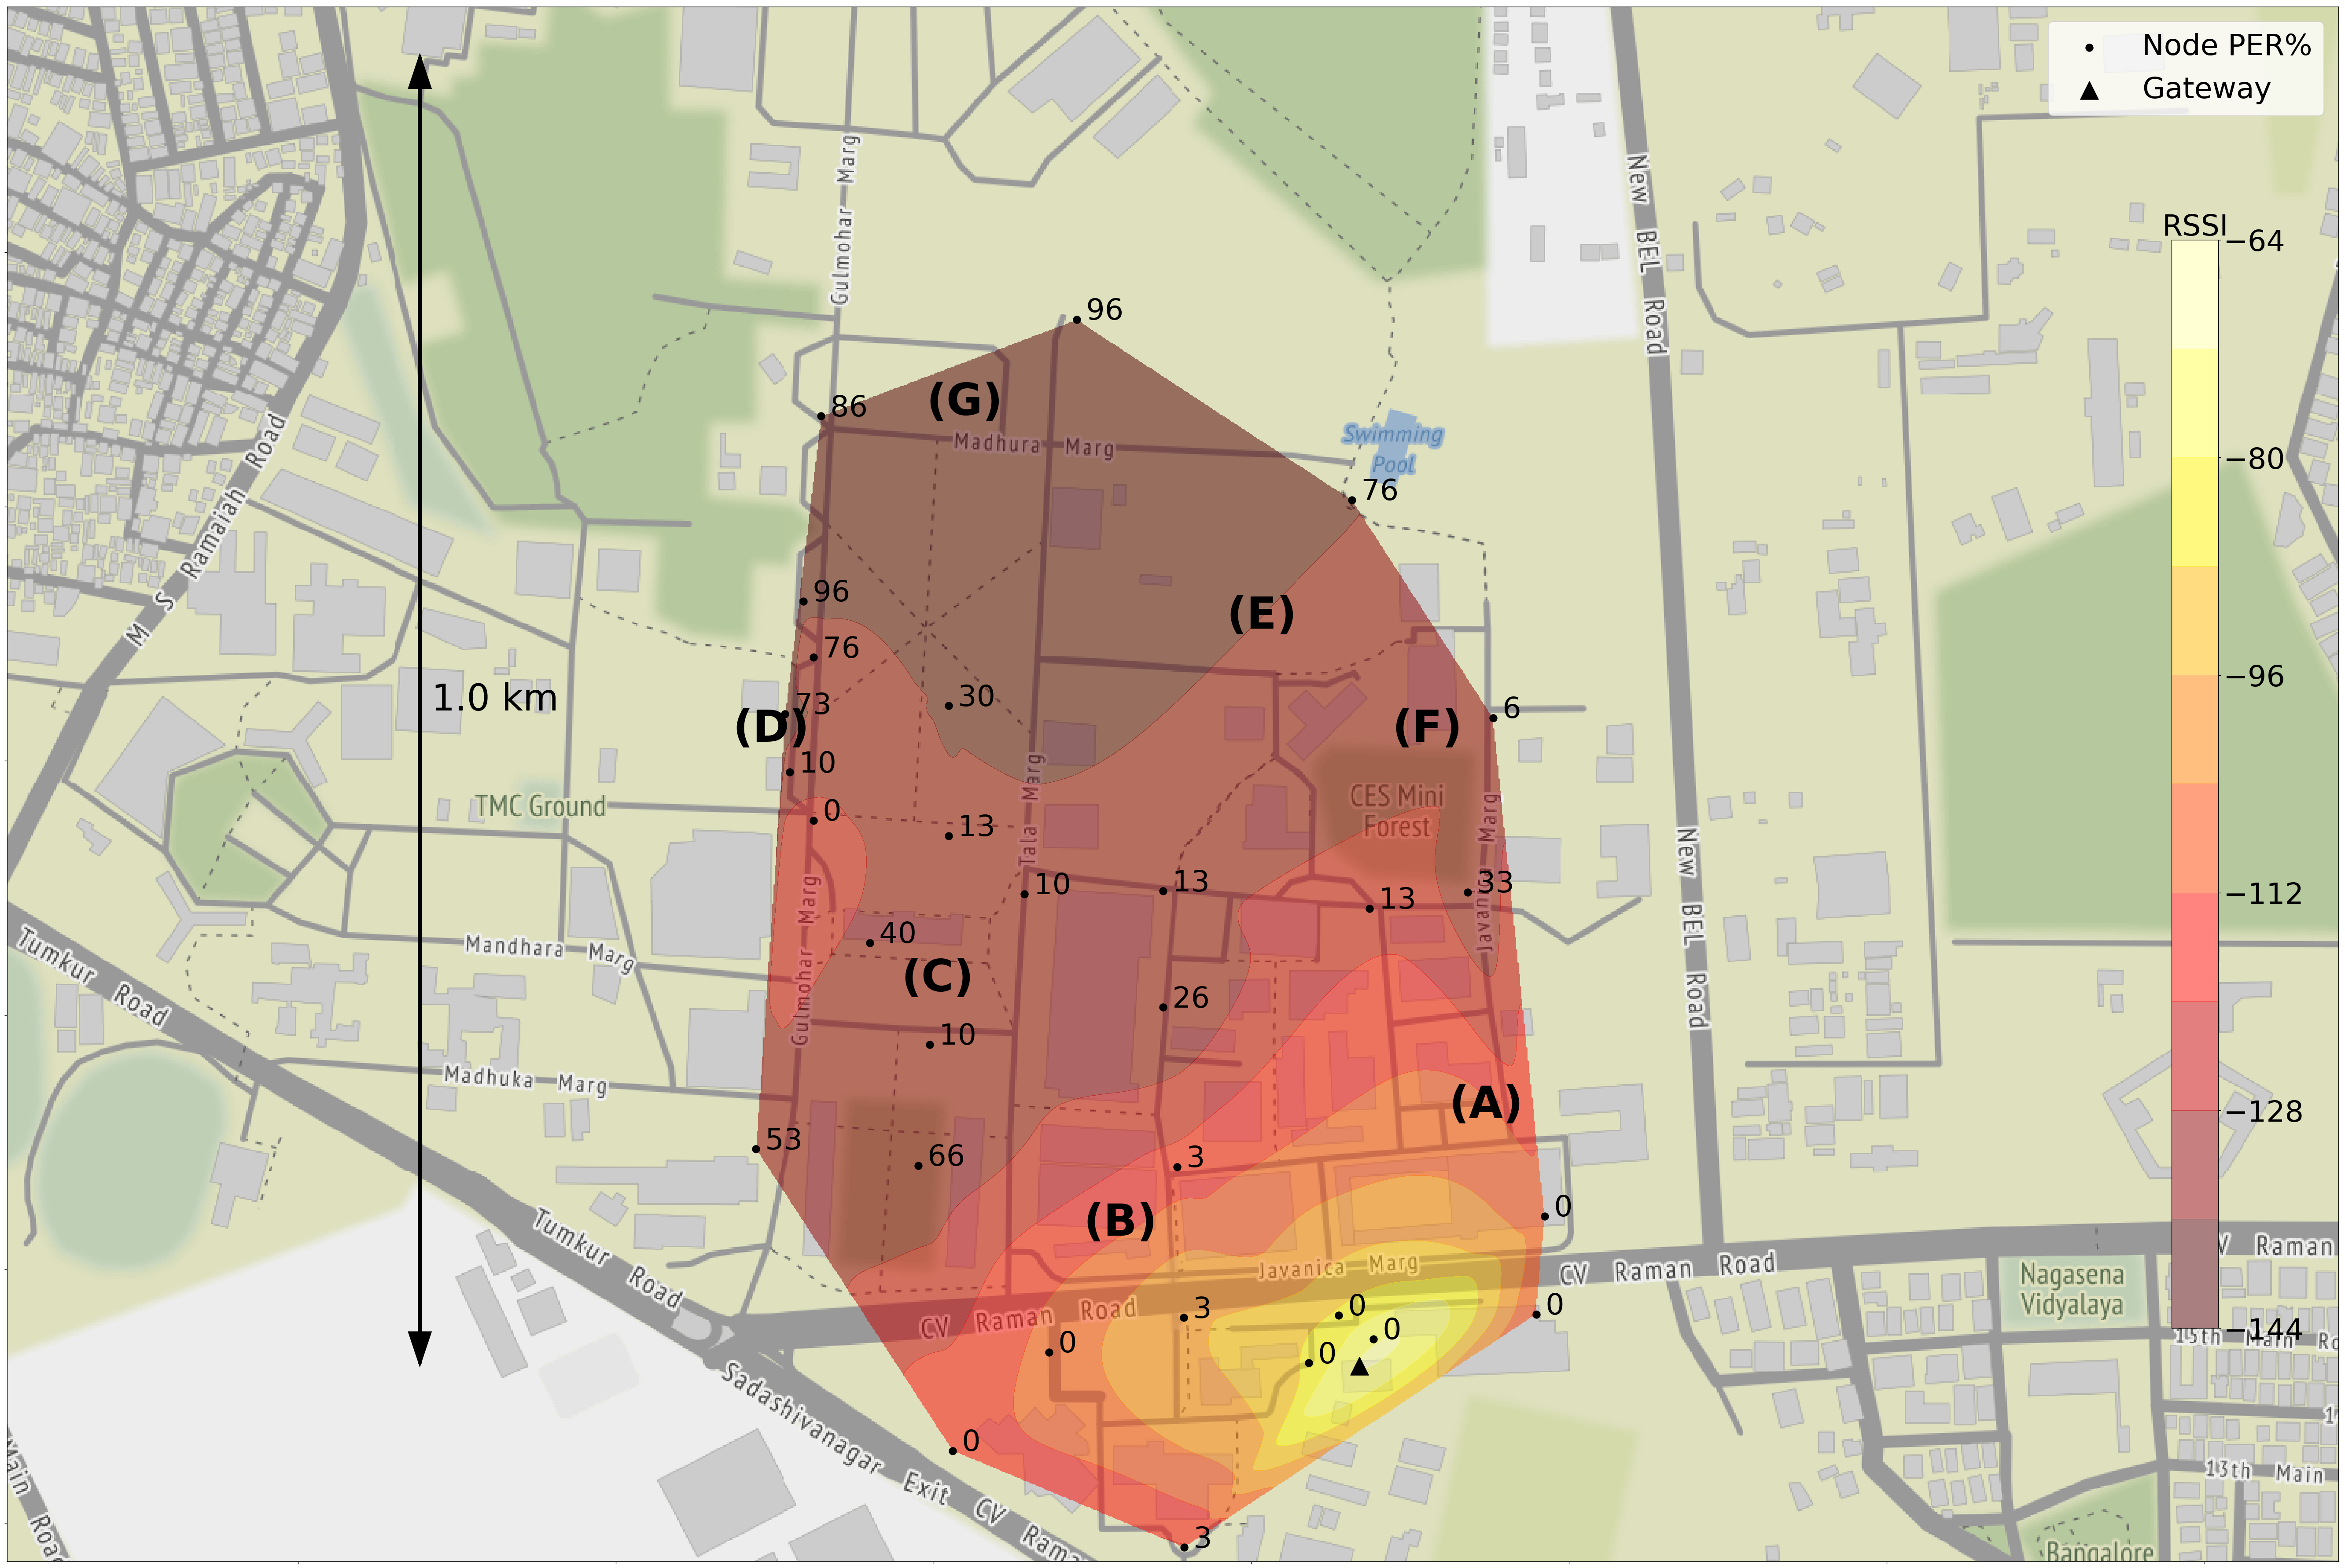

In [25]:
%matplotlib inline
'''
    Plot per spreadfactor samples on a map based on RSSI Value
'''
import contextily as ctx
from pyproj import Proj, transform

import numpy as np
from math import sin, cos, sqrt, atan2, radians
from numpy import ma
from numpy import genfromtxt
from scipy.interpolate import griddata

from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


''' Suppress scientific notation'''
np.set_printoptions(suppress=True)

''' Radius of the earth '''
R = 6373.0

''' Lower left corner and uper right corner on the map'''
ll = [13.01259, 77.5634]
ul = [13.02144, 77.5746]

''' Desired position of scale line '''
scale_0 = (13.013959, 77.563649)
oneKm = 0.00897403
scale_1 = (scale_0[0]+oneKm,scale_0[1])

lat1 = radians(scale_0[0])
lon1 = radians(scale_0[1])
lat2 = radians(scale_1[0])
lon2 = radians(scale_0[1])
dlat = lat1-lat2
dlon = lon1-lon2
a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))
distance = R * c

#SF7
# explMarkers = {"A":(13.01564,77.57092), "B":(13.01483,77.56834), "D":(13.01823,77.56586), "E":(13.01901,77.56935),
#                "C":(13.01651,77.56705)}

#SF12
explMarkers = {"A":(13.01564,77.57092), "B":(13.01483,77.56834), "D":(13.01823,77.56586), "E":(13.01901,77.56935), 
               "C":(13.01651,77.56705),"G":(13.02048,77.56723), "F":(13.01823,77.57052) }



''' Map url '''
url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'

''' Measurement parameters'''
gatewayLocation = (13.013931, 77.570290)
datafile = "./datasets/SFBased/12.csv"

''' Transform GPS lat lon to epsg3857 format for basemap'''
def transformToEpsg(lon, lat):
    return transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lon, lat)

fig = plt.figure(num=None, figsize=(80, 30), dpi=120, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
fig.tight_layout()

# longitude first, latitude second
ll_epsg = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), ll[1], ll[0])
ul_epsg = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), ul[1], ul[0]) 
gatewayLocation = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), gatewayLocation[1], gatewayLocation[0])

scale_0 = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), scale_0[1], scale_0[0])
scale_1 = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), scale_1[1], scale_1[0])

diff = (scale_1[1]-scale_0[1])/2
midpoint = (scale_0[0], scale_0[1]+diff)

''' Download the map'''
# basemap, extent = ctx.bounds2img(ll_epsg[0], ll_epsg[1], ul_epsg[0], ul_epsg[1], zoom=17, url=url)
''' Load data from csv file '''
dat = genfromtxt(datafile, delimiter=",")

dat[:,1], dat[:,0] = transformToEpsg(dat[:,1], dat[:,0])
for d in dat:
    if d[4]<0:
        d[3] = d[3]+d[4]
axis = (ll_epsg, ul_epsg)

''' Interpolate'''
xlin = np.arange(axis[0][0],axis[1][0], 1)
ylin = np.arange(axis[0][1],axis[1][1], 1)
xx, yy = np.meshgrid(xlin, ylin)
zi = griddata(np.flip(dat[:,0:2],axis=1), dat[:,3], (xx,yy), method="cubic")

''' Plots '''
ax.imshow(basemap, extent=extent)
cf = ax.contourf(xlin, ylin, zi,10,  cmap=plt.cm.hot,alpha=0.5, vmin=-150., vmax=-60.)
pts = ax.scatter(dat[:,1], dat[:,0], s=400, c='k',marker=".")
for dt in dat:
    ax.annotate(" " + str(int(dt[-1])),(dt[1], dt[0]), size=40)
gw = ax.scatter(gatewayLocation[0], gatewayLocation[1], s=600,c='k', marker="^")
plt.arrow(scale_0[0], scale_0[1], scale_1[0]-scale_0[0], scale_1[1]-scale_0[1], shape='full', 
          lw=5.0, length_includes_head=True, head_width=15, color="k")
plt.arrow(scale_1[0], scale_1[1], scale_0[0]-scale_1[0], scale_0[1]-scale_1[1], shape='full', 
          lw=5.0, length_includes_head=True, head_width=15, color="k")

for mrk in explMarkers:
    m = explMarkers[mrk]
    ax.annotate("("+mrk+")",(transformToEpsg(m[1], m[0])), size=60, weight="bold")

dstlbl = " " + str(round(distance,2)) + " km"
ax.annotate(dstlbl,midpoint, size=50)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.legend((pts, gw),("Node PER%", "Gateway"),numpoints=1, loc=1, facecolor='white', prop={'size': 40})
cbaxes = inset_axes(ax, width="2%", height="70%", loc=5, bbox_to_anchor=(-0.05,0,1,1),bbox_transform=ax.transAxes) 
cbar = fig.colorbar(cf,cax=cbaxes,fraction=0.015)
cbar.ax.set_title('RSSI', size=40)
cbar.ax.tick_params(labelsize=40) 